## Machine Learning - Classificação de Doenças Cardíacas
### MVP - Qualidade e Segurança de Sistemas Inteligentes

Este notebook aborda a criação de um modelo de classificação para prever a presença de doenças cardíacas. Incluindo uma Análise Exploratória de Dados (EDA) e uma avaliação de métricas mais detalhada para uma análise mais robusta.

### 1. Configuração do Ambiente e Carga dos Dados

In [8]:
# Configuração para não exibir warnings
import warnings
warnings.filterwarnings("ignore")

# Imports para manipulação de dados e modelagem
import pandas as pd
import numpy as np
import pickle
import os

# Imports para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Imports do Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Modelos a serem avaliados
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier

### 2. Carga e Limpeza Inicial dos Dados

In [9]:
# URL de importação do dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# Nomes das colunas
colunas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# Carrega o arquivo, tratando valores ausentes ('?')
dataset = pd.read_csv(url, header=None, names=colunas, na_values='?')

# Preenche os valores ausentes com a mediana da coluna, que é robusta a outliers
dataset.fillna(dataset.median(), inplace=True)

# Cria a variável alvo binária: 0 para ausência, 1 para presença de doença
dataset['target'] = (dataset['num'] > 0).astype(int)

### 3. Análise Exploratória de Dados (EDA)

Antes de modelar, vamos entender melhor nossos dados. Isso nos ajuda a validar a qualidade do dataset e a gerar insights.

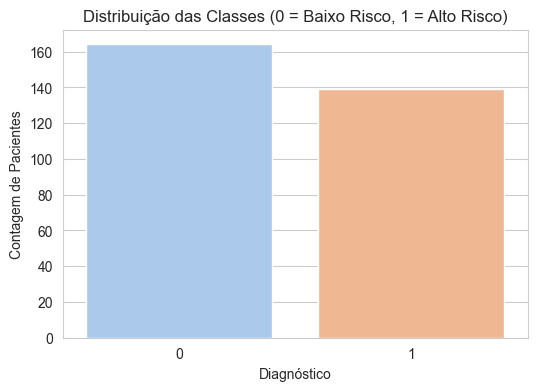

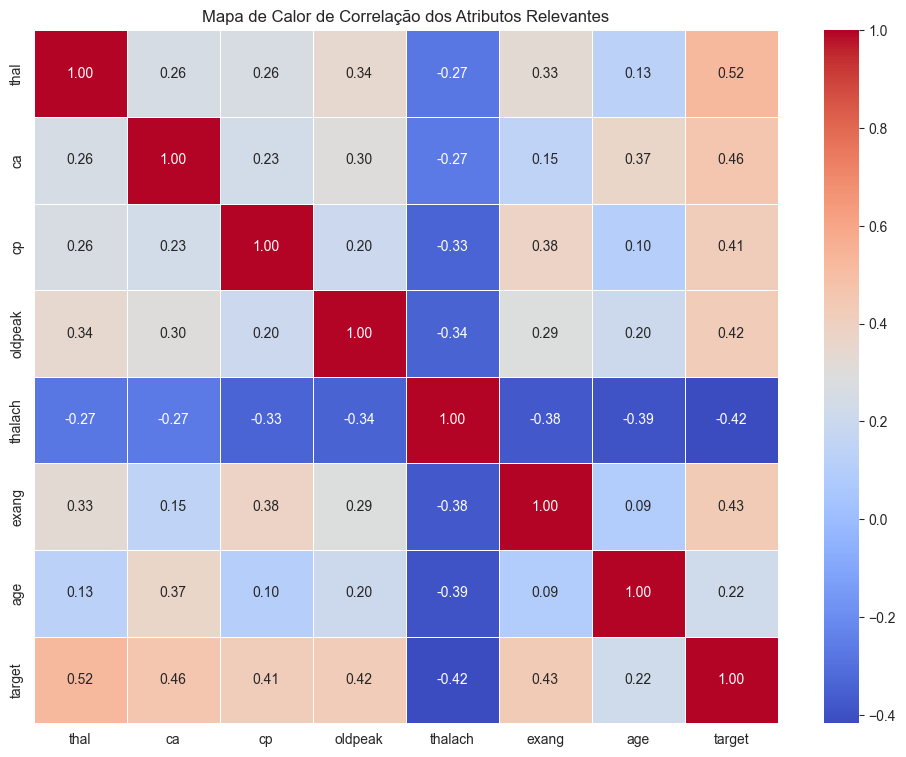

In [10]:
# Configura o estilo dos gráficos
sns.set_style('whitegrid')

# 1. Visualizar o balanceamento das classes
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=dataset, palette='pastel')
plt.title('Distribuição das Classes (0 = Baixo Risco, 1 = Alto Risco)')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem de Pacientes')
plt.show()

# Seleciona apenas os atributos que usaremos no modelo para a correlação
atributos_relevantes_corr = ['thal', 'ca', 'cp', 'oldpeak', 'thalach', 'exang', 'age', 'target']
dataset_corr = dataset[atributos_relevantes_corr]

# 2. Analisar o mapa de calor de correlação
plt.figure(figsize=(12, 9))
sns.heatmap(dataset_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlação dos Atributos Relevantes')
plt.show()

### 4. Preparação Final dos Dados para Modelagem

In [11]:
# Seleciona os 7 atributos mais relevantes + o alvo para o dataset final
atributos_relevantes = ['thal', 'ca', 'cp', 'oldpeak', 'thalach', 'exang', 'age', 'target']
dataset_reduzido = dataset[atributos_relevantes]

# Separação em X (features) e y (target)
array = dataset_reduzido.values
X = array[:, 0:-1]
y = array[:, -1]

# Separação em treino e teste com estratificação
test_size = 0.20
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed, stratify=y
)

# Configuração da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

### 5. Comparação de Modelos (Baseline)
Avaliamos o desempenho de vários algoritmos para estabelecer uma linha de base e confirmar nossa escolha do RandomForest.

Desempenho dos Modelos (Acurácia Média e Desvio Padrão):

LR: 0.826500 (0.051701)
KNN: 0.830000 (0.066558)
CART: 0.755667 (0.090913)
NB: 0.826667 (0.039236)
SVM: 0.822167 (0.042355)
RF: 0.776833 (0.045713)


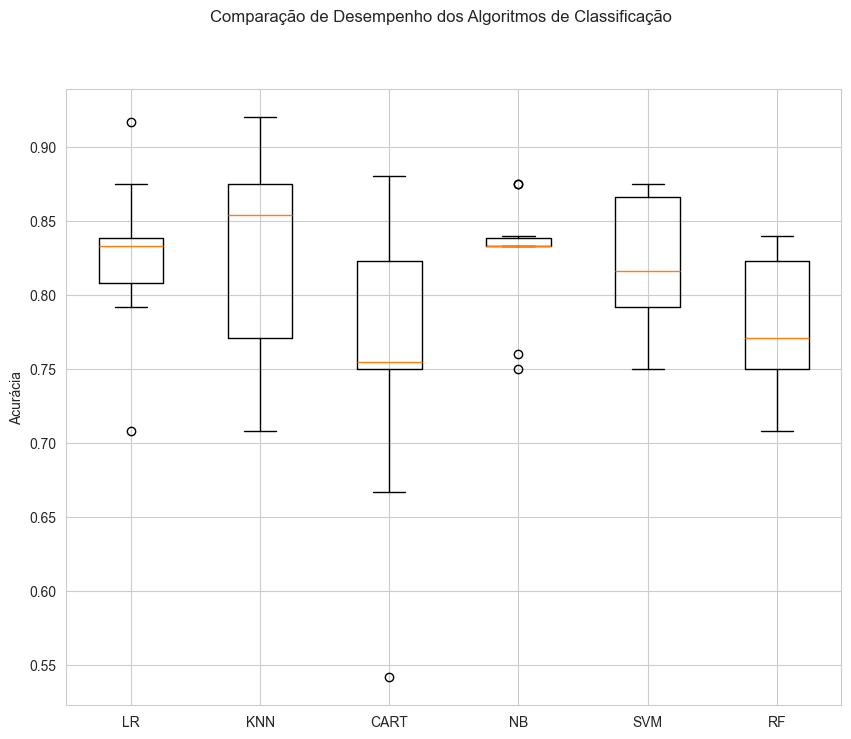

In [12]:
# Lista para armazenar os modelos
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC()))
models.append(("RF", RandomForestClassifier()))

# Avaliação de cada modelo
results = []
names = []
print("Desempenho dos Modelos (Acurácia Média e Desvio Padrão):\n")
for name, model in models:
    pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), (name, model)])
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Gráfico Boxplot para Comparação
fig = plt.figure(figsize=(10, 8))
fig.suptitle("Comparação de Desempenho dos Algoritmos de Classificação")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('Acurácia')
plt.show()

### 6. Otimização de Hiperparâmetros (GridSearchCV)
Com base na análise, o RandomForest (RF) é um dos modelos mais promissores. Vamos otimizá-lo.

In [13]:
pipeline_rf = Pipeline(steps=[
    ('MinMaxScaler', MinMaxScaler()),
    ('RF', RandomForestClassifier(random_state=seed))
])

param_grid = {
    'RF__n_estimators': [50, 100, 150],
    'RF__max_depth': [3, 5, 7]
}

grid = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid, scoring=scoring, cv=kfold)
grid.fit(X_train, y_train)

print(f"\nMelhor acurácia (Validação Cruzada): {grid.best_score_}")
print(f"Melhores hiperparâmetros: {grid.best_params_}")


Melhor acurácia (Validação Cruzada): 0.8343333333333334
Melhores hiperparâmetros: {'RF__max_depth': 3, 'RF__n_estimators': 50}


### 7. Avaliação Detalhada e Exportação do Modelo Final
Com os melhores hiperparâmetros, treinamos o modelo e o avaliamos com métricas detalhadas no conjunto de teste.

--- AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---
Acurácia: 0.9016\n
Matriz de Confusão:


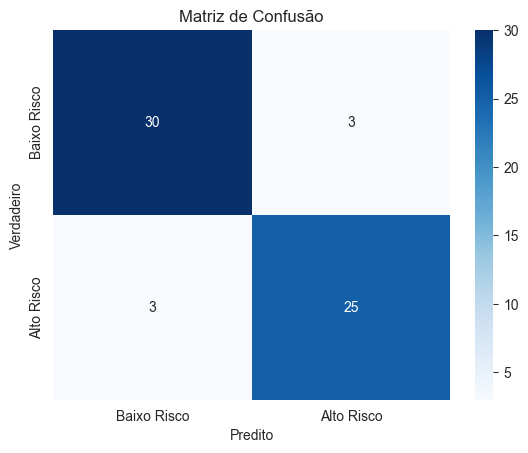

Relatório de Classificação:
              precision    recall  f1-score   support

  Sem Doença       0.91      0.91      0.91        33
  Com Doença       0.89      0.89      0.89        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61


Modelo salvo em: ../pipelines\heart_disease_pipeline.pkl
Dados de teste salvos em: ../data\test_dataset_heart.csv


In [ ]:
# Criando o pipeline final com os melhores hiperparâmetros
modelo_final = Pipeline(steps=[
    ('MinMaxScaler', MinMaxScaler()),
    ('RF', RandomForestClassifier(
        n_estimators=50, 
        max_depth=5, 
        random_state=seed
    ))
])

modelo_final.fit(X_train, y_train)
predictions = modelo_final.predict(X_test)

print("--- AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---")
print(f"Acurácia: {accuracy_score(y_test, predictions):.4f}\\n")

print("Matriz de Confusão:")
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo Risco', 'Alto Risco'], yticklabels=['Baixo Risco', 'Alto Risco'])
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

print("Relatório de Classificação:")
print(classification_report(y_test, predictions, target_names=['Baixo Risco', 'Alto Risco']))

# --- SALVANDO O MODELO PARA A API ---

# Diretórios
pipelines_dir = '../pipelines'
data_dir = '../data'

os.makedirs(pipelines_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# Salvando o pipeline final
pipeline_filename = os.path.join(pipelines_dir, 'heart_disease_pipeline.pkl')
with open(pipeline_filename, 'wb') as file:
    pickle.dump(modelo_final, file)

# Salvando dados de teste para os testes automatizados
colunas_reduzidas_X = ['thal', 'ca', 'cp', 'oldpeak', 'thalach', 'exang', 'age']
X_test_df = pd.DataFrame(X_test, columns=colunas_reduzidas_X)
y_test_df = pd.DataFrame(y_test, columns=['target'])
test_dataset_df = pd.concat([X_test_df, y_test_df], axis=1)

# Salvando no caminho corrigido
test_dataset_filename = os.path.join(data_dir, 'test_dataset_heart.csv')
test_dataset_df.to_csv(test_dataset_filename, index=False)

print(f"\nModelo salvo em: {pipeline_filename}")
print(f"Dados de teste salvos em: {test_dataset_filename}")